In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import python_utils as utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

In [ ]:
path='/Users/gunsls/Desktop/archive/train/train/'
for expression in os.listdir(path):
    print(str(len(os.listdir(path + expression))) + " " + expression + " images")

In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory('/Users/gunsls/Desktop/archive/train/train/',
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory('/Users/gunsls/Desktop/archive/test/test/',
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

In [ ]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

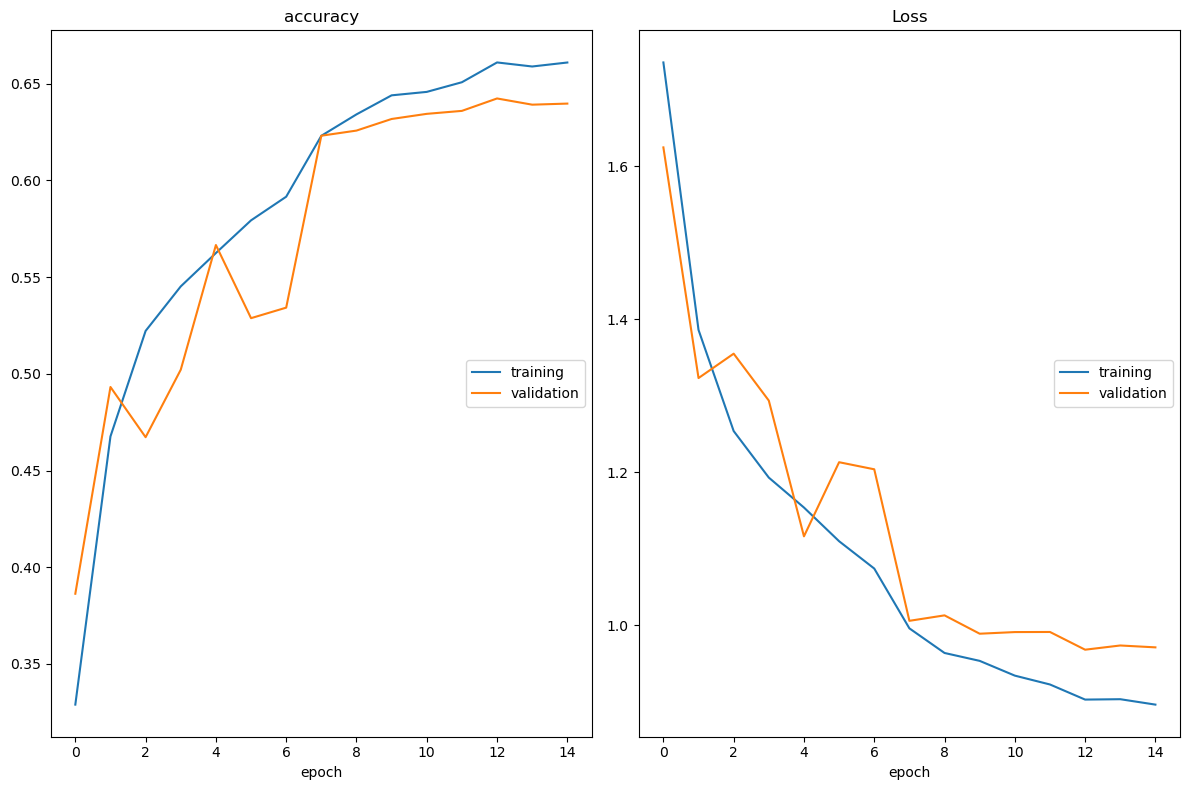

accuracy
	training         	 (min:    0.329, max:    0.661, cur:    0.661)
	validation       	 (min:    0.386, max:    0.642, cur:    0.640)
Loss
	training         	 (min:    0.896, max:    1.736, cur:    0.896)
	validation       	 (min:    0.968, max:    1.625, cur:    0.971)

Epoch 15: saving model to model_weights.h5
448/448 [==============================] - 945s 2s/step - loss: 0.8960 - accuracy: 0.6609 - val_loss: 0.9708 - val_accuracy: 0.6396 - lr: 1.0000e-05
CPU times: user 11h 14min 21s, sys: 53min 8s, total: 12h 7min 30s
Wall time: 4h 16min 5s


In [138]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import model_from_json
import numpy as np

import tensorflow as tf

class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

In [ ]:
import cv2

facec = cv2.CascadeClassifier('/Users/gunsls/Desktop/emo/haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        return fr

In [ ]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [ ]:
gen(VideoCamera())